<img src="../images/logo_VORTEX.png" width="200" height="auto" alt="Company Logo">

# Chapter 7: Wind Shear and Stability Analysis

_Overview_

This notebook demonstrates the process of plotting wind shear and stability information using both measurements and synthetic data.



_Specifically, we will:_

- Compute shear
- Plot shear against temperature, month, hour.
- Plot shear gainst stability classes
- Compute shear alphas using log law and polynomial law.
- Plot shear against alphas



_What you'll learn_

You will learn how shear is computed. We will also try to understand different meteorological patterns related to the shear and how they are related to other variables.

### Wind Shear

Wind shear is how the wind changes in the vertical profile. It is offten related to stability.

<img src="images/mixing.png" width="50%" />


There are anyway many other phenomena which alters it. For example such as:

- turbulent regimes.
- wind speeds.
- Low level jets.
- Varying rougness in offshore sites.



It is important for the design of wind farms and to choose the appropiate turbines. It for examples can determine different loads for similar histograms of the wind speed.

It can also change the overall power estimation for the same wind speeds at a single height.




### Log law alpha and polynomial alpha

If we want to characterize the shape of the vertical profile with a single value we can use the same aproach as in MCP. We can then define two methods:
<br />

__Log law__

```python
alpha = np.log(M2 / M1) / np.log(z2 / z1)
```
<br />

__Power law__

```python
slope, intercept, r_value, p_value, std_err = linregress(levs², M_tmp)
```


### Import Libraries

In [9]:
# =============================================================================
# 1. Import Libraries
# =============================================================================
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.stats import linregress
sys.path.append(os.path.join(os.getcwd(), '../examples'))
from example_2_read_txt_functions import *
from example_6_AtmosphericStabilityClassification_functions import build_ds_stability, plot_stability_frequency
from example_7_Shear_functions import *

# =============================================================================
# 2. Define Paths and Site
# =============================================================================

SITE = 'froya'
pwd = os.getcwd()
base_path = os.path.join(pwd, '../data')
vortex_netcdf = os.path.join(base_path, f'{SITE}/vortex/SERIE/vortex.serie.era5.utc0.nc')

print("\n" + "#"*26 + " Vortex F.d.C. 2025 " + "#"*26 + "\n")


########################## Vortex F.d.C. 2025 ##########################



In [10]:
#=============================================================================
# 3. Read Vortex Dataset and Basic Info
# =============================================================================

ds_vortex = xr.open_dataset(vortex_netcdf)
ds_vortex = ds_vortex[['M', 'Dir', 'T']]  # Keep only relevant variables

print("Levels in Vortex dataset:")
print(ds_vortex['lev'].values)

# Print mean wind speed at each level
ds_vortex_mean = ds_vortex.mean(dim='time')
print("Mean wind speeds at each level:")
for level, speed in zip(ds_vortex['lev'].values, ds_vortex_mean['M'].values.flatten()):
    print(f"Level {level:.0f} m: {speed:.2f} m/s")

Levels in Vortex dataset:
[  8.  28.  52.  80. 111. 145. 182. 220. 263. 330.]
Mean wind speeds at each level:
Level 8 m: 6.72 m/s
Level 28 m: 7.54 m/s
Level 52 m: 7.94 m/s
Level 80 m: 8.25 m/s
Level 111 m: 8.53 m/s
Level 145 m: 8.76 m/s
Level 182 m: 8.94 m/s
Level 220 m: 9.07 m/s
Level 263 m: 9.16 m/s
Level 330 m: 9.26 m/s


## Add Time Features and Plot Profiles by Hour and Month

We add hour and month as features, then plot wind profiles grouped by these.

/home/oriol/miniconda3/envs/python-def/lib/python3.13/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension hour because variable hour is not a coordinate. To create an index for hour, please first call `.set_coords('hour')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)
/home/oriol/miniconda3/envs/python-def/lib/python3.13/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension month because variable month is not a coordinate. To create an index for month, please first call `.set_coords('month')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


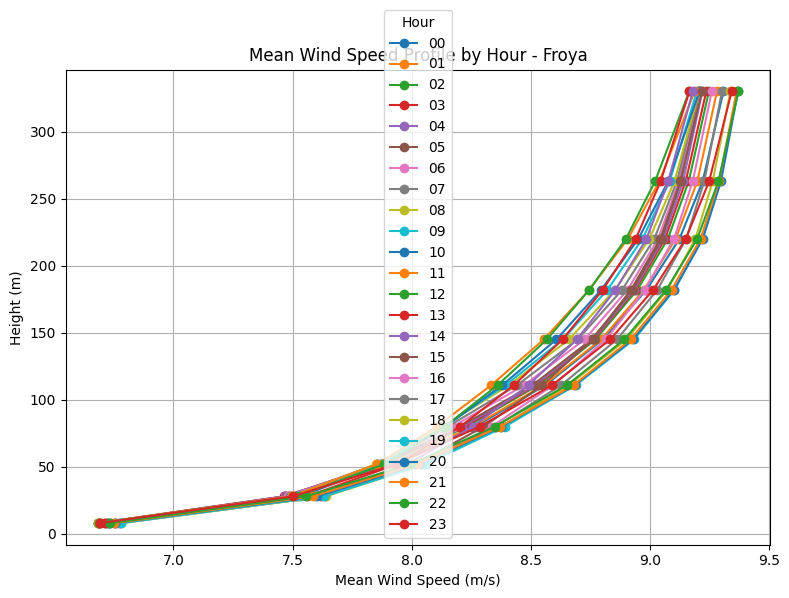

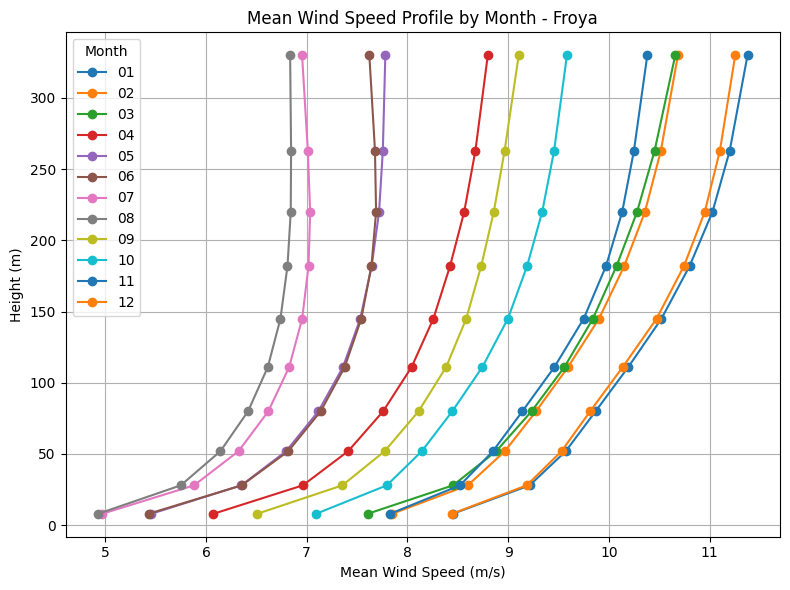

In [11]:
ds_vortex['hour'] = ds_vortex['time'].dt.hour
ds_vortex['month'] = ds_vortex['time'].dt.month

# Group by hour and month, then plot
ds_vortex_meanhour = ds_vortex.groupby('hour').mean(dim='time')
ds_vortex_meanmonth = ds_vortex.groupby('month').mean(dim='time')
plot_shear_profile_by(ds_vortex_meanhour, ds_vortex['lev'].values, "hour", SITE)
plot_shear_profile_by(ds_vortex_meanmonth, ds_vortex['lev'].values, "month", SITE)

## Temperature Binning and Profile Plot

We bin temperature at lev=2 and plot wind profiles grouped by temperature bins. We classify temperature in 5º bins to generate the variable T_bins.

/home/oriol/miniconda3/envs/python-def/lib/python3.13/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension T_bins because variable T_bins is not a coordinate. To create an index for T_bins, please first call `.set_coords('T_bins')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


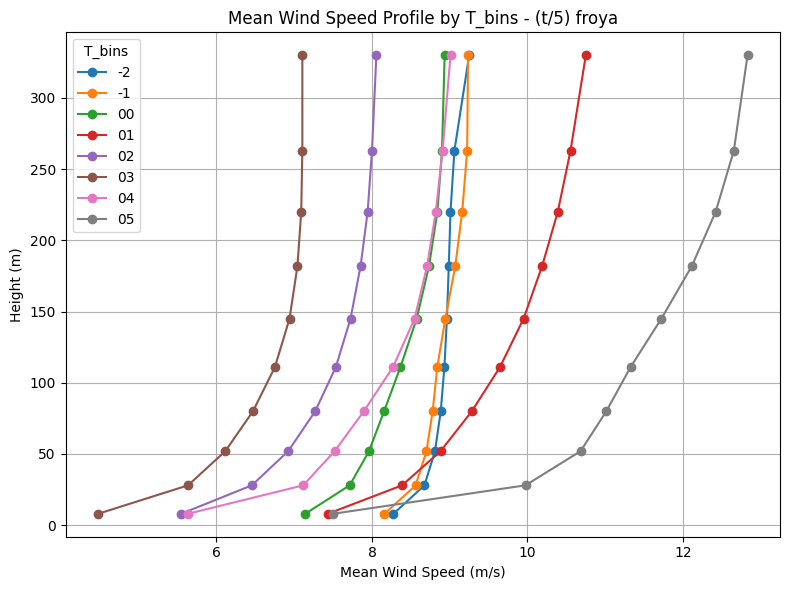

In [12]:
# Compute temperature bins at lev=2 (one value per time)
T_bins = (ds_vortex.isel(lev=2)['T'] / 5).astype(int).squeeze()

# Add T_bins as a variable with dimension 'time'
ds_vortex = ds_vortex.assign(T_bins=("time", T_bins.data))

# Group by T_bins and plot
ds_vortex_meanT = ds_vortex.groupby('T_bins').mean(dim='time')
plot_shear_profile_by(ds_vortex_meanT, ds_vortex['lev'].values, "T_bins", f"(T/5) {SITE}")

## Atmospheric Stability Classification and Profile Plot

We select two levels, compute stability, and plot wind profiles grouped by stability class.

Select two levels for which to compute the stability classification:
Selected levels: [ 52. 145.]
Levels for stability analysis: z1=52.0, z2=145.0
U and V variables are not present in the dataset. Calculating U and V.
Building stability dataset for levels z1: 52.0, z2: 145.0
z1 (52.0) or z2 (145.0) are not valid levels in the dataset.
Added levels z1 (52.0) and z2 (145.0) to the dataset and interpolated values.
Dataset de estabilitat construït amb les variables U, V i T.
Levs amb dades per U: [ 52. 145.]
Levs amb dades per V: [ 52. 145.]
Levs amb dades per T: [ 52. 145.]
Dataset de estabilitat completat amb les coordenades i atributs.
Variables M i Dir afegides al dataset de estabilitat.
Atributs de les variables afegits al dataset de estabilitat.
Richardson Number lev: [98.5]
Closest available level for M: 52.0
Closest available level for Dir: 52.0
Both variables are at the same level.
Extracting data for M and Dir at level 52.0 and 52.0 respectively.
<xarray.Dataset> Size: 20MB
Dimen

/home/oriol/miniconda3/envs/python-def/lib/python3.13/site-packages/xarray/core/concat.py:540: UserWarning: No index created for dimension stability because variable stability is not a coordinate. To create an index for stability, please first call `.set_coords('stability')` on this object.
  ds.expand_dims(dim_name, create_index_for_new_dim=create_index_for_new_dim)


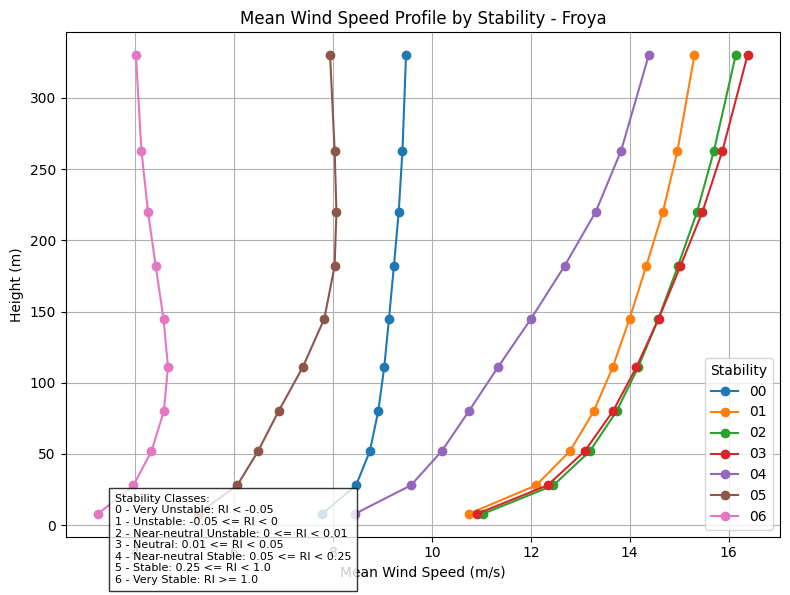

In [13]:
print("Select two levels for which to compute the stability classification:")
ds_vortex_stab = ds_vortex.isel(lev=[2, 5])
print("Selected levels:", ds_vortex_stab['lev'].values)

# Calculate stability between selected levels
z1, z2 = ds_vortex_stab['lev'].values
print(f'Levels for stability analysis: z1={z1}, z2={z2}')
ds_obs_stability = build_ds_stability(ds_vortex_stab, z1, z2)

# Add stability as a variable and plot grouped profiles
ds_vortex['stability'] = ds_obs_stability['stability']
ds_vortex_mean_stab = ds_vortex.groupby('stability').mean(dim='time')
plot_shear_profile_by(ds_vortex_mean_stab, ds_vortex['lev'].values, "stability", SITE)

## XY Plot: Temperature vs Stability

Scatter plot of temperature (lev=2) vs stability class.

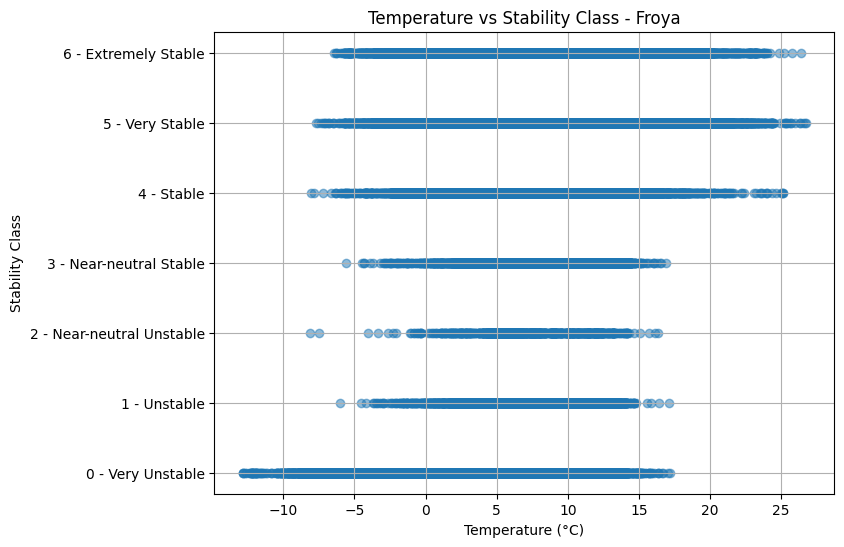

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(ds_vortex['T'].isel(lev=2), ds_vortex['stability'], alpha=0.5)
plt.xlabel('Temperature (°C)')
plt.ylabel('Stability Class')
plt.title(f'Temperature vs Stability Class - {SITE.capitalize()}')
plt.grid()
plt.yticks(ticks=range(7), labels=[
    "0 - Very Unstable",
    "1 - Unstable",
    "2 - Near-neutral Unstable",        
    "3 - Near-neutral Stable",
    "4 - Stable",
    "5 - Very Stable",
    "6 - Extremely Stable",
])
plt.show()

## Compute Shear Exponent Alpha for Each Timestamp

Calculate shear exponent alpha between two selected levels for each timestamp.

```python
alpha = np.log(M2 / M1) / np.log(z2 / z1)
```


Shear exponent alpha first lev 2: 0.048
Shear exponent alpha (std) first lev 2: 0.199


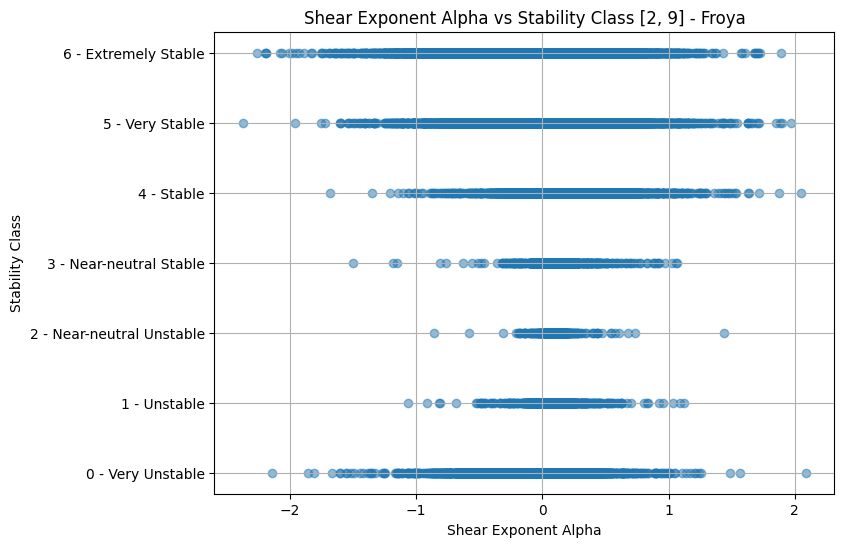

In [15]:
for firstlev in [2]:
    secondlev = firstlev + 7
    z1, z2 = ds_vortex['lev'].values[firstlev], ds_vortex['lev'].values[secondlev]
    M1 = ds_vortex['M'].isel(lev=firstlev)  # Wind speed at z1
    M2 = ds_vortex['M'].isel(lev=secondlev)  # Wind speed at z2

    # Compute shear exponent alpha for each timestamp
    alpha = np.log(M2 / M1) / np.log(z2 / z1)

    # Add alpha as a variable to the dataset
    ds_vortex['alpha'] = alpha

    # Print summary statistics
    print(f"Shear exponent alpha first lev {firstlev}: {np.nanmean(alpha):.3f}")
    print(f"Shear exponent alpha (std) first lev {firstlev}: {np.nanstd(alpha):.3f}")
    #plot XY of alpha vs stability
    plt.figure(figsize=(8, 6))
    plt.scatter(ds_vortex['alpha'], ds_vortex['stability'], alpha=0.5)
    plt.xlabel('Shear Exponent Alpha')
    plt.ylabel('Stability Class')
    plt.title(f'Shear Exponent Alpha vs Stability Class [{firstlev}, {secondlev}] - {SITE.capitalize()}')
    plt.grid()
    plt.yticks(ticks=range(7), labels=[
        "0 - Very Unstable",
        "1 - Unstable",
        "2 - Near-neutral Unstable",        
        "3 - Near-neutral Stable",
        "4 - Stable",
        "5 - Very Stable",
        "6 - Extremely Stable",
    ])
    plt.show()

## Fit Shear Exponent Alpha Using All Levels for Each Timestamp

Fit a polynomial to wind speed vs height squared for each timestamp, and plot results.

```python
slope, intercept, r_value, p_value, std_err = linregress(levs^2, M_tmp)
```

In [ ]:
levs = ds_vortex['lev'].values
levs2 = levs**2
alphas = []
r_values = []

for i in range(ds_vortex.sizes['time']):
    M_tmp = ds_vortex['M'].isel(time=i).values.flatten()
    slope, intercept, r_value, p_value, std_err = linregress(levs2, M_tmp)
    alphas.append(slope)
    r_values.append(r_value)

ds_vortex['alpha_all_levels'] = (('time'), np.array(alphas))
ds_vortex['r_value'] = (('time'), np.array(r_values))

print(f"Shear exponent alpha using all levels (mean): {np.nanmean(ds_vortex['alpha_all_levels'].values):.3f}")
print(f"Shear exponent alpha using all levels (std): {np.nanstd(ds_vortex['alpha_all_levels'].values):.3f}")

# Plot XY of alpha_all_levels vs stability
plt.figure(figsize=(8, 6))
plt.scatter(ds_vortex['alpha_all_levels'], ds_vortex['stability'], alpha=0.5)
plt.xlabel('Shear Exponent Alpha (All Levels)')
plt.ylabel('Stability Class')
plt.title(f'Shear Exponent Alpha (All Levels) vs Stability Class - {SITE.capitalize()}')
plt.grid()
plt.yticks(ticks=range(7), labels=[
    "0 - Very Unstable",
    "1 - Unstable",
    "2 - Near-neutral Unstable",        
    "3 - Near-neutral Stable",
    "4 - Stable",
    "5 - Very Stable",
    "6 - Extremely Stable",
])
plt.show()

What do you think the wind regimes are most influencedby? Stability plays a role but you can not make a matching of shear by solely it. The wind pattern is influenced by many factors. <br />

You can also see that alpha (the wind shear exponent) plays a significant role in defining the wind profile. It is influenced by stability, but also by other factors such as temperature gradients and surface roughness. It can anyway not be determined and graphical plots help to better understand the wind shear.

### Thank you for completing this Notebook! 
### *Other references available upon request.*

Remember, you can tune up to:

- Check for different level pairs for staibility and alpha computation.
- Plots against other variables.
- Plot subsamples.


**Don't hesitate to [contact us](https://vortexfdc.com/contact/) for any questions and information.**

__Thank you to @albertbosch for the code help__

## Change Log


| Date (YYYY-MM-DD) | Version | Changed By | Change Description                         |
|-------------------|---------|------------|--------------------------------------------|
| 2025-09-19        | 0.9     | Oriol L    | Notebook creation                          |

<hr>

## <h3 align="center"> © Vortex F.d.C. 2025. All rights reserved. <h3/>